In [1]:
#!/usr/bin/env python

#comment out if not using jupyter
%matplotlib inline 

#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import odeint
from scipy.optimize import curve_fit

#from scipy.stats import pearsonr,spearmanr
#from scipy.interpolate import interp1d


In [2]:
## functions to do the whole fitting process ##

#use nested functions to pass in initial viral load 
#becaues this determines other initial conditions
def make_solver(V0,flg):

    #fixed parameters for fitting
    aS  = 70;    #constant growth rate of susceptibles [cells/uL/day]
    Bt0 = 1e-4   #infection rate of T-cells [uL/cells-day]/[uL]
    dI  = 0.8    #active death rate [1/day]
    p   = 5e4    # burst rate of virus from cells [virions/cell]
    g   = 23     #virus clearance rate [1/day]
    lam = 1e-4   #latency probability []
    thL = 5.2e-4 #latent clearance rate [1/day]
    aE  = 1e-4;  #initial E cell concentration [cells/uL]*[uL]

    if flg=='params':
        return aS,Bt0,dI,p,g,lam,thL,aE
    
    #complete HIV primary infection model for fitting
    def full_model(X,t,aS,dS,Bt0,tau,lam,dI,thL,k,aE,dE,E50,w,p,g):
        dY = np.zeros(7);
        S=X[0]; AU=X[1]; AP=X[2]; LU=X[3]; LP=X[4]; E=X[5]; V=X[6];    
        dY[0] = aS - dS*S - Bt0*S*V                         #susceptible cells
        dY[1] = (1-tau)*(1-lam)*Bt0*S*V - dI*AU - k*E*AU    #active unproductively infected
        dY[2] = tau*(1-lam)*Bt0*S*V - dI*AP - k*E*AP        #active productively infected
        dY[3] = (1-tau)*lam*Bt0*S*V - thL*LU                #latent unproductively infected
        dY[4] = tau*lam*Bt0*S*V - thL*LP                    #latent productively infected
        dY[5] = aE + w*E*(AP+AU)/(E+E50) - dE*E;            #adaptive immune system
        dY[6] = p*AP - g*V - Bt0*S*V                        #virus
        return dY
    
    #the model that has the right number of estimated params and will be fit
    def solve_model(tt,dS,tau,k,dE,E50,w):  
        #set up initial conditions
        I0=g/p*V0 #quasistatic approximation for VL and infected cells
        S0=aS/dS-I0; E0=aE/dE #compute equilibria for these    
        #calculate the rest of initial conditions from more quasistatic approx
        X0=np.array([S0,
                     I0*(1-tau)*(1-lam), #unproductive active
                     I0*tau*(1-lam),     #productive active
                     I0*(1-tau)*lam,     #unproductive latent
                     I0*tau*lam,         #productive latent
                     E0,
                     V0])

        #solve model using initialize for initial conditions
        sol=odeint(full_model, X0, tt, (aS,dS,Bt0,tau,lam,dI,thL,k,aE,dE,E50,w,p,g), mxstep=10000) 
        VL=np.log10(sol[:,6]*1e3) #viral load as usual units copies/mL
        
        if flg=='fit':
            return VL
        if flg=='sim':
            return sol
        else:
            print('specify your model to be fit or simulated')
        
    return solve_model

#function to make arrays for boundaries during fitting process
def make_bounds(guess,fac):
    bounds=tuple([tuple(np.array(guess)/fac),tuple(np.array(guess)*fac)])
    return bounds

In [3]:
#import data from RV217 trial
RV217=pd.read_csv('data/DBRout_RV217.csv')

ppts=RV217['ID'].unique()
N=len(ppts) #number of participants

In [4]:
#list of ppts I like by eye
dpins=[40283,40134,40646,40503,40577,40512,40511,40491,40436,
40363,40353,40265,40257,40250,40231,40168,40123,40100,40094,40061,
40007,10742,10739,10723,10463,10435,10428,10220,10203,10066]

In [5]:
#constrain the participants to good data sets automatically or manually
autoselect=True
if autoselect:
    goodppts=[]
    for ppt in ppts:

        fitdat=RV217[RV217['ID']==ppt] #loop through each individual    

        data_t=np.array(fitdat['days'])-min(fitdat['days']) #rescale
        data_V=np.array(fitdat['log10VL'],dtype=float)
        
        if len(data_V)>6:
            if max(data_V)>5:
                if data_V[0]<6:
                    goodppts.append(ppt)

else:
    goodppts=dpins

len(goodppts)

30

In [6]:
#list of initial guesses of parameters to fit
dS  = 0.2;   #susceptible death rate [1/day] 
tau = 0.05   #productive infection probability []
k   = 0.3;   #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;   #immune cell multiplier [1/day]
dE  = 0.002; #immune death rate [1/day]
E50 = 250;   #50 pct max E cell concentration [cells/uL]*[uL]

guessed_params=dS,tau,k,dE,E50,w


In [7]:
#loop through all good individual data sets and fit 
estimated_params=[]
for ppt in goodppts:
    
    fitdat=RV217[RV217['ID']==ppt] #loop through each individual    

    data_t=np.array(fitdat['days'])-min(fitdat['days']) #rescale
    data_V=np.array(fitdat['log10VL'])
        
    #model fit
    po,pc=curve_fit(make_solver(V0=data_V[0],flg='fit'), 
                    data_t, data_V, 
                    p0=guessed_params, 
                    bounds=make_bounds(guessed_params,10),
                    #sigma=0.1*np.ones(len(data_V)),
                    sigma=1/data_V,
                    absolute_sigma=False,
                    max_nfev=1e3, verbose=1, xtol=1e-15, ftol=1e-15, gtol=1e-15)

    estimated_params.append(list(po))
    
    


`xtol` termination condition is satisfied.
Function evaluations 37, initial cost 1.0401e+02, final cost 4.1768e+01, first-order optimality 8.49e+00.
`xtol` termination condition is satisfied.
Function evaluations 72, initial cost 2.9556e+02, final cost 2.9579e+01, first-order optimality 7.85e+01.
`xtol` termination condition is satisfied.
Function evaluations 46, initial cost 2.9810e+02, final cost 3.7518e+01, first-order optimality 4.23e+01.
`xtol` termination condition is satisfied.
Function evaluations 38, initial cost 1.4294e+02, final cost 2.5591e+01, first-order optimality 6.17e+00.
`xtol` termination condition is satisfied.
Function evaluations 28, initial cost 7.0596e+01, final cost 3.6477e+01, first-order optimality 2.44e+02.
`xtol` termination condition is satisfied.
Function evaluations 37, initial cost 1.3693e+02, final cost 2.2391e+00, first-order optimality 1.74e+01.
`xtol` termination condition is satisfied.
Function evaluations 26, initial cost 1.8710e+02, final cost 1.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log10


`xtol` termination condition is satisfied.
Function evaluations 40, initial cost 1.2696e+02, final cost 2.2224e+01, first-order optimality 2.12e+01.
`xtol` termination condition is satisfied.
Function evaluations 36, initial cost 2.5534e+02, final cost 6.3200e+01, first-order optimality 2.07e+02.
`xtol` termination condition is satisfied.
Function evaluations 100, initial cost 2.4036e+02, final cost 1.0369e+02, first-order optimality 2.62e+02.
`xtol` termination condition is satisfied.
Function evaluations 64, initial cost 5.0770e+02, final cost 1.1740e+02, first-order optimality 5.30e+00.
`xtol` termination condition is satisfied.
Function evaluations 33, initial cost 9.5838e+01, final cost 5.0493e+01, first-order optimality 2.83e+01.
`xtol` termination condition is satisfied.
Function evaluations 45, initial cost 1.9994e+02, final cost 5.5938e+01, first-order optimality 1.30e+02.


In [8]:
#plot the fits separately?

if False:
    sim_t=np.linspace(0,100,1e3);

    pptind=0
    for ppt in goodppts:

        fitdat=RV217[RV217['ID']==ppt] #loop through each individual    

        data_t=np.array(fitdat['days'])-min(fitdat['days']) #rescale
        data_V=np.array(fitdat['log10VL'])

        dS,tau,k,dE,E50,w=estimated_params[pptind]
        sim_V=make_solver(data_V[0],'fit')(sim_t,dS,tau,k,dE,E50,w)

        plt.figure()
        plt.scatter(data_t/7,data_V)
        plt.plot(sim_t/7,sim_V)
        pptind+=1

        #plt.xlim([-1,10])
        #plt.xticks(range(0,10,2))
        plt.ylim([1,9])
        plt.yticks(range(1,9,2))
        plt.ylabel('viral load $log_{10}$(RNA copies/mL)')
        plt.xlabel('time (weeks after first positive')
        plt.tight_layout()
        plt.savefig('figures/fits/'+str(ppt)+'.pdf',dpi=600)
    plt.close('all')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


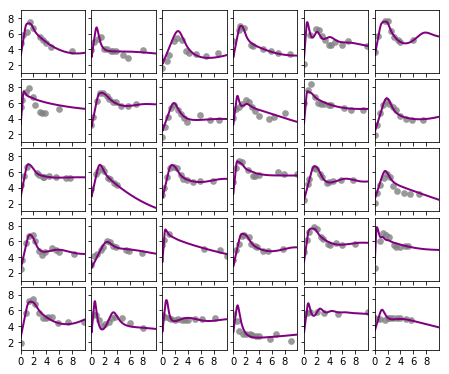

In [9]:
#plot model fitting results
nx=6; ny=int(np.ceil(len(goodppts)/nx));
fig,axarr=plt.subplots(ny,nx,sharey=True,sharex=True,
                       figsize=(nx*1.25,ny*1.25),
                       gridspec_kw={'wspace':0.1,'hspace':0.1})

sim_t=np.linspace(0,100,1e3);

#plot fits together
pptind=0
for ppt in goodppts:
    
    fitdat=RV217[RV217['ID']==ppt] #loop through each individual    

    data_t=np.array(fitdat['days'])-min(fitdat['days']) #rescale
    data_V=np.array(fitdat['log10VL'])
    
    dS,tau,k,dE,E50,w=estimated_params[pptind]
    sim_V=make_solver(data_V[0],'fit')(sim_t,dS,tau,k,dE,E50,w)

    ax=axarr[int(pptind/nx)][pptind%nx]
    ax.scatter(data_t/7,data_V,c='gray',marker='o',lw=0,s=45,alpha=0.8)
    ax.plot(sim_t/7,sim_V,lw=2,color='purple')
    pptind+=1

plt.xlim([0,10])
plt.xticks(range(0,10,2))
plt.ylim([1,9])
plt.yticks(range(0,11,2))
#axarr[2][0].set_ylabel('viral load $log_{10}$(RNA copies/mL)',fontsize=14)
#axarr[3][5].set_xlabel('time (weeks post estimated date of infection)',fontsize=14)
#plt.tight_layout()
plt.savefig('figures/myrobb_fits.pdf',dpi=600)


medians for below
0.3491595396278778
0.06773225718361925
0.7174251960167877
0.00317810926627803
242.94660215313147
2.7722497272371376


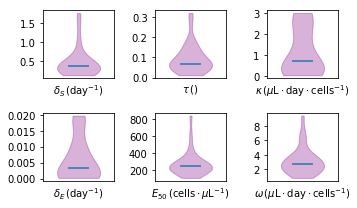

In [10]:
#make violin plots of all parameters
ep=np.array(estimated_params)

pnamez=[r'$\delta_S \, (\mathrm{day}^{-1})$',
        r'$\tau \, ()$',
        r'$\kappa \, (\mu\mathrm{L}\cdot \mathrm{day}\cdot \mathrm{cells}^{-1})$',
        r'$\delta_E \, (\mathrm{day}^{-1})$',
        r'$E_{50} \, (\mathrm{cells}\cdot\mu\mathrm{L}^{-1})$',
        r'$\omega \, (\mu\mathrm{L}\cdot \mathrm{day}\cdot \mathrm{cells}^{-1})$']
    
plt.figure(figsize=(5,3))
print('medians for below')
#ylimz=[[1e-2,10],[1e-2,1],[1e-2,10],[1e-4,0.1],[50,1e3],[1,10]]
ylimz=[[0,2],[0,0.4],[0,10],[0,0.02],[0,300],[0,10]]
for i in range(len(estimated_params[0])):
    plt.subplot(231+i)

    #plt.scatter(np.random.normal(1,0.05,[len(po_arr[i,:])]),po_arr[i,:],alpha=0.2,s=10,color='gray')
    #plt.boxplot(po_arr[i,:],widths=0.5)
    vp=plt.violinplot(ep[:,i],widths=0.6,showextrema=False,showmedians=True)
    print(np.median(ep[:,i]))
    for pc in vp['bodies']:
        pc.set_facecolor('purple')
        pc.set_edgecolor('purple')

    #plt.yscale('log')
    plt.xlim([0.5,1.5])
    plt.locator_params(nbins=5)

    #plt.ylim(ylimz[i])
    plt.xlabel(pnamez[i])
    #plt.legend([pz[i]],loc=2)
    plt.xticks([])
    #plt.xticks([1],[pz[i]])
plt.tight_layout()
plt.savefig('figures/myrobb_paramfitsVIOL.pdf',dpi=600)


In [14]:
#check all the reproductive numbers and store all the variable parameters
R0=[]; pls=[]

aS,Bt0,dI,p,g,lam,thL,aE=make_solver(0,'params')

for i in range(len(estimated_params)):
    dS,tau,k,dE,E50,w=estimated_params[i]        
    
    R0i=aS*Bt0*tau*(1-lam)*p/g/dS/(dI+k*aE/dE)
    #R0i=aS*Bt0*tau*(1-lam)*p/g/dS/dI-k*aE/dE #old wrong version!
    
    R0.append(R0i); # basic reproductive number after first positive
    pls.append([R0[i],dS,tau,k,dE,E50,w])
    
pd.DataFrame.to_csv(pd.DataFrame(
                    np.array(pls)),#columns=['R0','dS','tau','k','dE','E50','w']),
                    'data/viral_dynamics.csv')



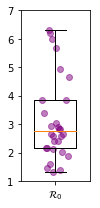

In [15]:
plt.figure(figsize=(1.5,3))
plt.scatter(np.random.normal(1,0.2,len(R0)),R0,color='purple',alpha=0.5)
plt.boxplot(R0,widths=1.2)

plt.xlim([0,2])
plt.xticks([1],[r'$\mathcal{R}_0$'])
plt.ylim([1,7])
#plt.yticks(range(0,11,2))
plt.tight_layout()
plt.savefig('figures/myrobb_R0s.pdf',dpi=600)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


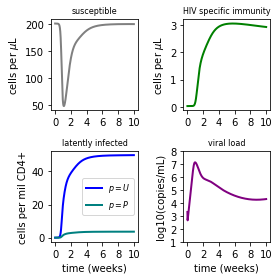

In [16]:
#simulate host-cell states

#dS,tau,k,dE,E50,w=estimated_params[2]
dS,tau,k,dE,E50,w=np.median(estimated_params,0)

sim_t=np.linspace(0,70,1e3);

sol=make_solver(2,'sim')(sim_t,dS,tau,k,dE,E50,w)

t=sim_t/7

plt.figure(figsize=(4,4))

plt.subplot(221)
plt.plot(t,sol[:,0],'gray',lw=2)
plt.ylabel('cells per $\mu$L')
plt.title('susceptible',fontsize=8)

'''
plt.subplot(152)
plt.plot(t,sol[:,1],'red',lw=2)
plt.plot(t,sol[:,2],'orange',lw=2)
plt.ylabel('cells per $\mu$L')
plt.legend(['$U$','$P$'],fontsize=8)
plt.title('actively infected',fontsize=8)
'''

plt.subplot(222)
plt.plot(t,sol[:,5],'green',lw=2) #immune cells
#plt.plot(t,sol[:,5]*k/(dI+sol[:,5]*k)*100,'green',lw=2) #fraction from immunity (It cancels out)
plt.ylabel('cells per $\mu$L')
#plt.ylabel('killing %')
#plt.ylim([0,100])
plt.title('HIV specific immunity',fontsize=8)

plt.subplot(223)
plt.plot(t,sol[:,3]*1000,'blue',lw=2) #divide by 1000 CD4+ T cells and then multiply by 1 million
plt.plot(t,sol[:,4]*1000,'teal',lw=2)
plt.ylabel('cells per mil CD4+')
plt.legend(['$p=U$','$p=P$'],fontsize=8)
plt.title('latently infected',fontsize=8)
plt.xlabel('time (weeks)')

plt.subplot(224)
plt.plot(t,np.log10(sol[:,6]*1e3),'purple',lw=2)
plt.ylabel('log10(copies/mL)')
plt.yticks(range(1,9,1))
plt.title('viral load',fontsize=8)
plt.xlabel('time (weeks)')

for i in range(4):
    plt.subplot(221+i)
    plt.xticks(range(0,11,2))

#fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
plt.tight_layout()
plt.savefig('figures/myrobb_median.pdf')
